# Data Cleaning Exercise

 

Data Scientists and Analysts are often tasked to clean and analyze datasets. We are working with an external research firm who specializes in the application of artificial intelligence to forecasting prices of financial instruments. This firm has developed a proprietary system, called “4sight”, to forecast prices of certain instruments.

To demonstrate the effectiveness of their forecasting system, the vendor has sent us attached sample dataset. The dataset includes signal values generated by the 4sight system as well as historical prices for a well-known broad market ETF.

A Portfolio Manager has asked you to:

1.      Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

2.      Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

3.      (Extra credit) Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_excel('/content/drive/MyDrive/millennium interview/Sample Dataset.xlsx')
df.head()

,Date,Signal,Open,High,Low,Close,Adj Close
0,2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
1,2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2,2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
3,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
4,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


# Observation

In [5]:
# check if is in ascending order, any duplication, and the uniqueness of date
# looks smooth
assert(df.duplicated().sum() == 0)
assert(pd.Index(df['Date']).is_monotonic)
assert(df['Date'].nunique()==df.shape[0])

In [6]:
# check if there is any missing data and the correctness of the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB


In [7]:
# Close > High
# min of Close is negative
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Signal,1038.0,16.766190,3.095783,0.000000,14.691150,17.298240,19.030890,35.434147
Open,1038.0,141.847360,18.475574,94.080002,132.132496,146.769997,155.367496,172.789993
High,1038.0,142.691801,18.470255,95.400002,132.912495,147.959999,156.287495,173.389999
Low,1038.0,140.907746,18.404504,93.639999,130.542503,145.634995,154.422500,171.949997
Close,1038.0,141.840973,18.497010,94.790001,131.824993,146.885002,155.289993,196.279999
Adj Close,1038.0,136.341060,21.427837,-152.277847,125.290491,142.667732,151.798325,168.842270


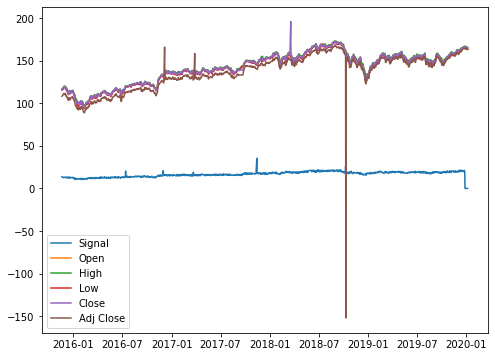

In [8]:
# Negative price value is found in Adj Close
# There are few spikes in the signal and the price data
# The signal drops at last weridly

plt.figure(figsize=(8,6))
plt.plot(df['Date'], df[['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']])
plt.legend(['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close'])

<AxesSubplot:>

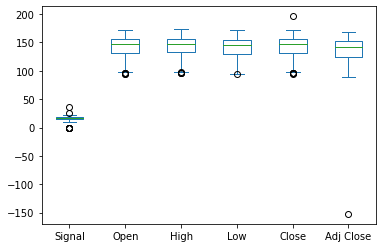

In [9]:
# it "seems" there are outliers in every column
df.plot.box()

In [10]:
# Negative value is found in Adj Close which is incorrect
print('Numbers of negative value for each column')
for col in df.columns[1:]:
  print(col, np.sum(df[col]<0))

Numbers of negative value for each column
Signal 0
Open 0
High 0
Low 0
Close 0
Adj Close 1


In [11]:
# Normal situation should be like this:
# - Low < Open, Close < High
# - High > Low
# - Close >= Adj. Close
# Check any flawness in the price data
print('Count when')
print("- high < open:", np.sum(df['Open'] > df['High']))
print("- high < close:", np.sum(df['Close'] > df['High']))
print("- low > open:", np.sum(df['Low'] > df['Open']))
print("- low > close:", np.sum(df['Low'] > df['Close']))
print("- high < low:", np.sum(df['Low'] > df['High']))
print("- close < adj. close:", np.sum(df['Close'] - df['Adj Close'] < 0))

Count when
- high < open: 1
- high < close: 4
- low > open: 4
- low > close: 15
- high < low: 2
- close < adj. close: 2


# Data Cleaning
I firstly clean the price data, then the signal data.

## Check Close and Adj. Close

Fixed row: 262, 338, 585, 732



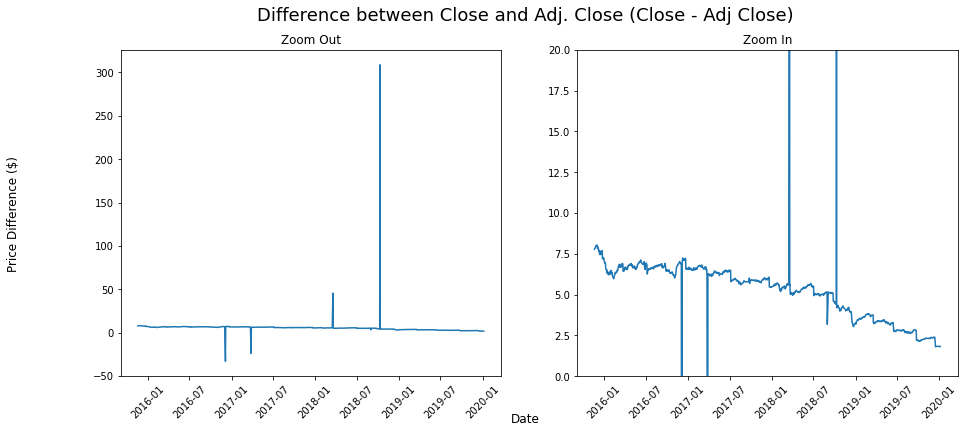

In [12]:
# Some spikes in the difference between Close and Adj Close
# visually: 5 spikes in 2k16, 17, 18
# combining the information above, I think there are some annomalies in both closing price data

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(df.Date, (df.Close - df['Adj Close']))
axes[1].plot(df.Date, (df.Close - df['Adj Close']))

axes[1].set_ylim([0, 20])

fig.suptitle('Difference between Close and Adj. Close (Close - Adj Close)', fontsize=18)

fig.supxlabel('Date')
fig.supylabel('Price Difference ($)')

axes[0].set_title('Zoom Out')
axes[1].set_title('Zoom In')

for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

plt.show()

,Date,Signal,Open,High,Low,Close,Adj Close
700,2018-08-24,21.655552,171.149994,171.779999,171.020004,171.589996,166.455048
701,2018-08-27,20.197865,172.110001,172.940002,171.619995,171.839996,166.697601
702,2018-08-28,19.862856,172.160004,172.479996,171.100006,172.000000,166.852783
703,2018-08-29,21.440569,172.020004,172.770004,171.460007,172.500000,167.337814
704,2018-08-30,20.870663,172.169998,173.229996,171.820007,172.360001,167.202026
705,2018-08-31,20.705795,171.960007,173.389999,171.949997,172.020004,168.842270
706,2018-09-04,20.457543,172.789993,173.119995,171.119995,172.250000,167.095306
707,2018-09-05,21.455656,172.179993,172.229996,170.360001,171.789993,166.649048
708,2018-09-06,21.346674,172.169998,172.479996,170.419998,170.630005,165.523804
709,2018-09-07,21.712125,170.210007,171.449997,169.660004,170.539993,165.436493


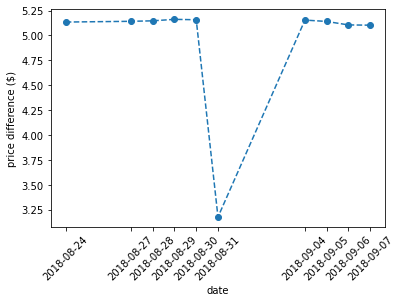

In [13]:
# I realized that there is a little spike at index 705 (2018-08-31).
# I dont know why Adj Close rise a bit but it looks ok on the value.

plt.plot(df.Date[700:710], (df.Close - df['Adj Close'])[700:710], '--o')
plt.ylabel('price difference ($)')
plt.xlabel('date')
plt.xticks(df.Date[700:710], rotation=45)

display(df.iloc[700:710])

In [14]:
# check the other spikes
df[abs(df['Close'] - df['Adj Close']) > 10]

,Date,Signal,Open,High,Low,Close,Adj Close
262,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079
338,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221
732,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847


In [15]:
# value of Adj Close should be wrong

print("When Close < Adj Close:")
for idx in df[df['Close'] - df['Adj Close'] < 0].index:
    display(df.iloc[idx-1:idx+2])

print("\nWhen Adj Close < 0:")
for idx in df[df['Adj Close'] < 0].index:
    display(df.iloc[idx-1:idx+2])
    
print("\nWhen Close is too high:")
for idx in [585]:
    display(df.iloc[idx-1:idx+2])

When Close < Adj Close:


,Date,Signal,Open,High,Low,Close,Adj Close
261,2016-12-02,14.990113,130.940002,131.470001,130.520004,130.899994,124.042938
262,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079
263,2016-12-06,15.885051,133.520004,134.910004,132.740005,134.589996,127.539658


,Date,Signal,Open,High,Low,Close,Adj Close
337,2017-03-24,15.131940,134.949997,135.470001,133.860001,134.490005,128.339050
338,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637
339,2017-03-28,16.215369,134.279999,135.899994,134.139999,135.789993,129.579605



When Adj Close < 0:


,Date,Signal,Open,High,Low,Close,Adj Close
731,2018-10-09,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219
732,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847
733,2018-10-11,18.794839,155.809998,157.320007,153.509995,153.570007,149.369629



When Close is too high:


,Date,Signal,Open,High,Low,Close,Adj Close
584,2018-03-16,19.385186,156.979996,158.270004,156.750000,157.800003,152.174042
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221
586,2018-03-20,19.177721,156.669998,157.020004,155.770004,156.240005,150.669647


In [16]:
# to correct the data, I use interpolation to calculate:
# - the adj close by close, and
# - the close by adj close

# From the result, since the values visually are quite similar to me,
# looks like the price data is incorrectly input:
# e.g. 152.277847 becomes -152.277847
# But I still decide to replace by the interpolated values as they are logically reasonable to me

# the adj close by close
for idx in [262, 338, 732]:
    prev_cls, current_cls, nxt_cls = df.iloc[idx-1:idx+2]['Close']
    prev_adj_cls, current_adj_cls, nxt_adj_cls = df.iloc[idx-1:idx+2]['Adj Close']
    est_adj_cls = (current_cls - nxt_cls) / (prev_cls - nxt_cls) * (prev_adj_cls - nxt_adj_cls) + nxt_adj_cls
    print('original:', df.loc[idx, 'Adj Close'],'; by interpolation:', est_adj_cls)
    df.loc[idx, 'Adj Close'] = est_adj_cls

# the close by adj close
for idx in [585]:
    prev_cls, current_cls, nxt_cls = df.iloc[idx-1:idx+2]['Close']
    prev_adj_cls, current_adj_cls, nxt_adj_cls = df.iloc[idx-1:idx+2]['Adj Close']
    est_cls = (current_adj_cls - nxt_adj_cls) / (prev_adj_cls - nxt_adj_cls) * (prev_cls - nxt_cls) + nxt_cls
    print('original:', df.loc[idx, 'Close'],'; by interpolation:', est_cls)
    df.loc[idx, 'Close'] = est_cls

original: 166.175079 ; by interpolation: 126.17508318582917
original: 158.577637 ; by interpolation: 128.57762047141972
original: -152.277847 ; by interpolation: 152.27784447726606
original: 196.279999 ; by interpolation: 156.28000470941942


## Check Low

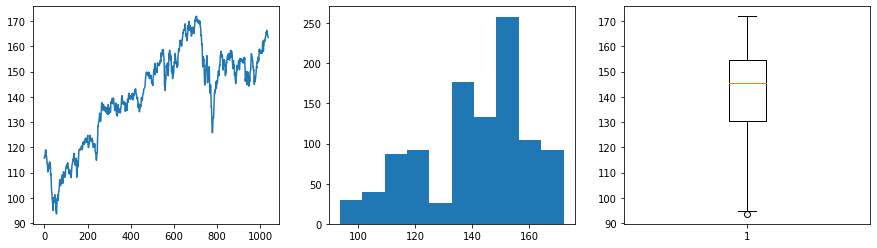

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(5*3, 4))
axes[0].plot(df.Low)
axes[1].hist(df.Low)
axes[2].boxplot(df.Low)
plt.show()

In [18]:
# When Open < Low, either Open or Low is abnormal
# 407 might duplicate 406 open => replace open by low
# 577 and 671: Low > High and Low > Open and Close => Replace Low by the lowest value in OHLC
# 893: Low > Open and Close => Replace Low by the lowest value in OHLC

for idx in df[df.Open < df.Low].index:
    display(df.iloc[idx-1:idx+2])

,Date,Signal,Open,High,Low,Close,Adj Close
406,2017-07-03,16.803540,141.339996,142.500000,141.300003,142.100006,135.600998
407,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998
408,2017-07-05,15.282748,141.699997,141.850006,140.699997,141.589996,135.114380


,Date,Signal,Open,High,Low,Close,Adj Close
576,2018-03-06,18.797986,154.429993,155.389999,152.800003,155.369995,149.830704
577,2018-03-07,18.885411,154.460007,156.929993,157.220001,156.740005,151.151840
578,2018-03-08,19.721756,156.899994,157.470001,155.500000,156.419998,150.843262


,Date,Signal,Open,High,Low,Close,Adj Close
670,2018-07-13,19.637023,167.850006,168.729996,167.419998,167.419998,162.409836
671,2018-07-16,20.010313,167.759995,168.029999,169.960007,166.770004,161.779312
672,2018-07-17,21.448342,166.750000,168.000000,166.589996,167.509995,162.497147


,Date,Signal,Open,High,Low,Close,Adj Close
891,2019-06-07,18.477306,150.350006,151.509995,150.020004,150.860001,147.617294
892,2019-06-10,19.055083,151.449997,153.139999,152.449997,151.750000,148.488159
893,2019-06-11,19.123134,152.869995,153.229996,150.580002,151.300003,148.047836


In [19]:
df[df.Close < df.Low].index

Int64Index([455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 577, 671, 739,
            892, 966],
           dtype='int64')

In [20]:
# When Close < Low, the index are from 455 to 464 (consecutive) and 577, 671, 739, 892, 966
# For 455 to 464, I expand the period to see which day starts to go wrong
# I've found that from 453 to 464, the closing prices keep constant (139.110001)
# I guess the annomally starting from 454 or 455 to 464 in the closing price data

display(df.iloc[452:466])

,Date,Signal,Open,High,Low,Close,Adj Close
452,2017-09-06,16.318515,139.740005,140.000000,139.080002,139.460007,133.656616
453,2017-09-07,16.478500,139.589996,139.690002,138.589996,139.110001,133.321198
454,2017-09-08,15.518587,138.929993,139.770004,138.619995,139.110001,133.321198
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198
460,2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198
461,2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198


In [21]:
# estimate Close by the average of High and Low
df.loc[df.iloc[453:465].index, 'Close'] = ((df.iloc[453:465].High + df.iloc[453:465].Low)/2)

# conduct interpolation to estimate Adj Close data.
prev_cls, nxt_cls = df.loc[[452, 465], 'Close']
prev_adj_cls, nxt_adj_cls = df.loc[[452, 465], 'Adj Close']

for idx in df.iloc[453:465].index:
    current_cls = df.loc[idx, 'Close']
    current_adj_cls = df.loc[idx, 'Adj Close']

    ratio = (current_cls - prev_cls) / (nxt_cls - prev_cls)
    est_adj_cls = ratio * (nxt_adj_cls - prev_adj_cls) + prev_adj_cls

    df.loc[idx, 'Adj Close'] = est_adj_cls

In [22]:
# for the non-consecutive index where Close < Low
for idx in [577, 671, 739, 892, 966]:
    display(df.iloc[idx-1:idx+2])

# Low > High at row 577 and 671
# I believe that the low price is wrong

print("When Low > High, the index are", df[df.Low>df.High].index)

# for row 577, 671 and 892, it can be clearly observed that Low > Open and Low > Close. Low price should be wrong
print("When Low > Close and Low > Open, the index are", df[(df.Low>df.Open)&(df.Low>df.Close)].index)

# for row 739, 966
print('for row 739, the Open price in the following day (row 740) seems agreeing on the Close price at 739.')
print('for row 966, the Open price in the following day (row 967) seems agreeing on the Close price at 966.')
print('therefore, I believe that the low price is wrong also')

,Date,Signal,Open,High,Low,Close,Adj Close
576,2018-03-06,18.797986,154.429993,155.389999,152.800003,155.369995,149.830704
577,2018-03-07,18.885411,154.460007,156.929993,157.220001,156.740005,151.151840
578,2018-03-08,19.721756,156.899994,157.470001,155.500000,156.419998,150.843262


,Date,Signal,Open,High,Low,Close,Adj Close
670,2018-07-13,19.637023,167.850006,168.729996,167.419998,167.419998,162.409836
671,2018-07-16,20.010313,167.759995,168.029999,169.960007,166.770004,161.779312
672,2018-07-17,21.448342,166.750000,168.000000,166.589996,167.509995,162.497147


,Date,Signal,Open,High,Low,Close,Adj Close
738,2018-10-18,17.729952,157.410004,157.630005,154.369995,155.000000,150.760529
739,2018-10-19,17.461385,155.470001,156.360001,154.740005,153.360001,149.165390
740,2018-10-22,17.476161,153.919998,154.449997,152.520004,153.029999,148.844406


,Date,Signal,Open,High,Low,Close,Adj Close
891,2019-06-07,18.477306,150.350006,151.509995,150.020004,150.860001,147.617294
892,2019-06-10,19.055083,151.449997,153.139999,152.449997,151.750000,148.488159
893,2019-06-11,19.123134,152.869995,153.229996,150.580002,151.300003,148.047836


,Date,Signal,Open,High,Low,Close,Adj Close
965,2019-09-23,18.772685,154.860001,155.949997,154.559998,155.309998,152.507370
966,2019-09-24,18.630976,155.149994,155.289993,152.839996,152.429993,150.205444
967,2019-09-25,17.644770,152.279999,154.360001,151.800003,154.100006,151.851105


When Low > High, the index are Int64Index([577, 671], dtype='int64')
When Low > Close and Low > Open, the index are Int64Index([577, 671, 892], dtype='int64')
for row 739, the Open price in the following day (row 740) seems agreeing on the Close price at 739.
for row 966, the Open price in the following day (row 967) seems agreeing on the Close price at 966.
therefore, I believe that the low price is wrong also


In [23]:
for idx in [407, 577, 671, 739, 892, 966]:
    avg_low = df.loc[[idx-1, idx+1], 'Low'].mean()
    min_OHLC = min(df.loc[idx,['Open', 'High', 'Close']])
    if avg_low > min_OHLC:
        print('row', idx, 'replaced by min(Open, High, Close)')
        avg_low = min_OHLC
    else:
        print('row', idx, 'replaced by avg(Low at t-1, Low at t+1)')
    df.loc[idx, 'Low'] = min_OHLC

row 407 replaced by avg(Low at t-1, Low at t+1)
row 577 replaced by avg(Low at t-1, Low at t+1)
row 671 replaced by min(Open, High, Close)
row 739 replaced by min(Open, High, Close)
row 892 replaced by avg(Low at t-1, Low at t+1)
row 966 replaced by min(Open, High, Close)


## Check High

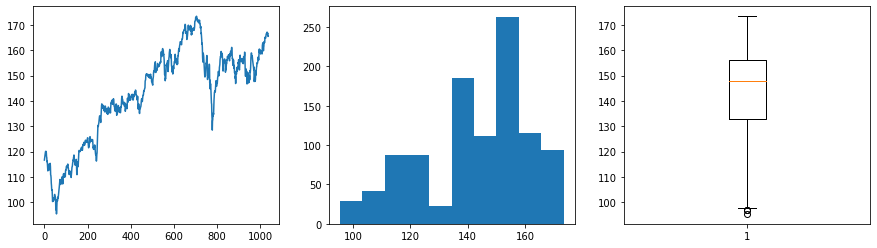

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(5*3, 4))
axes[0].plot(df.High)
axes[1].hist(df.High)
axes[2].boxplot(df.High)
plt.show()

In [25]:
# decide whether High is wrong

# As the closing price at 430 and opening price at 432 are quite close to the Open and Close at 431 with respectively.
# The High at 431 might be wrong

# for row 766, the Close and Adj Close prices in the following day (row 767) and the current Adj Close seem agreeing on the Close price at 766.
# for row 983, the Close and Adj Close prices in the following day (row 984) and the current Adj Close seem agreeing on the Close price at 983.

for idx in df[(df.Close>df.High)].index:
    display(df.iloc[idx-1:idx+2])

print("Open > High:", df[(df.Open>df.High)].index)
print("Close > High:", df[(df.Close>df.High)].index)

,Date,Signal,Open,High,Low,Close,Adj Close
430,2017-08-04,16.759826,139.910004,140.320007,139.490005,140.210007,134.375412
431,2017-08-07,16.298805,140.440002,140.350000,139.710007,140.440002,134.595871
432,2017-08-08,15.694927,140.410004,141.789993,139.690002,140.000000,134.174164


,Date,Signal,Open,High,Low,Close,Adj Close
765,2018-12-04,16.663803,153.750000,154.130005,147.139999,147.520004,143.485123
766,2018-12-06,16.904044,145.449997,147.099997,143.429993,147.199997,143.173874
767,2018-12-07,17.650821,147.139999,148.259995,143.270004,144.020004,140.080856


,Date,Signal,Open,High,Low,Close,Adj Close
982,2019-10-16,18.413906,151.210007,152.270004,151.139999,151.550003,149.338303
983,2019-10-17,18.878412,152.289993,153.309995,152.050003,153.339996,151.102173
984,2019-10-18,18.487006,152.929993,153.500000,151.449997,152.610001,150.382828


Open > High: Int64Index([431], dtype='int64')
Close > High: Int64Index([431, 766, 983], dtype='int64')


In [26]:
# replaced by max(Open, High, Close)
for idx in [431, 766, 983]:
    max_OHLC = max(df.loc[idx,['Open', 'Low', 'Close']])
    df.loc[idx, 'High'] = max_OHLC

## Final Check on Price Data

In [27]:
print('Count when')
print("- high < open:", np.sum(df['Open'] > df['High']))
print("- high < close:", np.sum(df['Close'] > df['High']))
print("- low > open:", np.sum(df['Low'] > df['Open']))
print("- low > close:", np.sum(df['Low'] > df['Close']))
print("- high < low:", np.sum(df['Low'] > df['High']))
print("- close < adj. close:", np.sum(df['Close'] - df['Adj Close'] < 0))

Count when
- high < open: 0
- high < close: 0
- low > open: 0
- low > close: 0
- high < low: 0
- close < adj. close: 0


## Check Signal

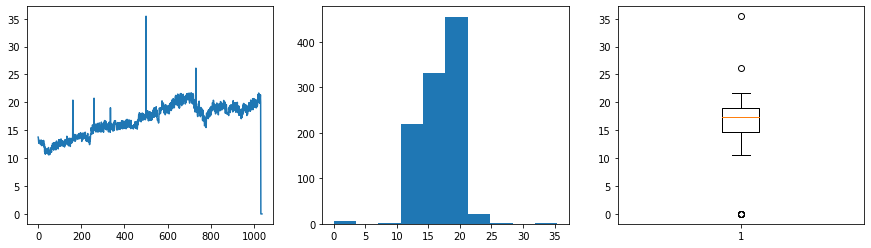

In [28]:
# there are outliers (potentially)
# any trend in signal? non-stationary? what if i least square the signal to predict the y?

fig, axes = plt.subplots(1, 3, figsize=(5*3, 4))
axes[0].plot(df.Signal)
axes[1].hist(df.Signal)
axes[2].boxplot(df.Signal)
plt.show()

In [29]:
# for potential outliers near the maximum
print("Count signal > 30:", np.sum(df.Signal > 30))
print("Count signal > 25:", np.sum(df.Signal > 25))

Count signal > 30: 1
Count signal > 25: 2


In [30]:
df[df.Signal > 25].index

Int64Index([500, 731], dtype='int64')

In [31]:
# Abnormal signal at index = 500 and 731 (increased and decreased sharply)
# We can replace the abnormal value by the mean value of the Signal at t-1 and t+1
display(df.iloc[499:502])
display(df.iloc[730:733])

df.loc[500, 'Signal'] = np.mean(df.loc[[499, 501], 'Signal'])
df.loc[731, 'Signal'] = np.mean(df.loc[[730, 732], 'Signal'])

,Date,Signal,Open,High,Low,Close,Adj Close
499,2017-11-10,17.628384,146.710007,147.100006,146.350006,146.570007,140.810852
500,2017-11-13,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274
501,2017-11-14,17.456319,146.059998,146.490005,145.589996,146.210007,140.465012


,Date,Signal,Open,High,Low,Close,Adj Close
730,2018-10-08,20.367731,161.770004,162.399994,160.550003,161.820007,157.393982
731,2018-10-09,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219
732,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,152.277844


In [32]:
# the last 6 signal data = 0. looks strange
# we can drop the last 6 signal
df.tail(8)

,Date,Signal,Open,High,Low,Close,Adj Close
1030,2019-12-24,21.361876,166.449997,166.699997,166.039993,166.679993,164.850052
1031,2019-12-26,20.016643,166.830002,166.979996,166.360001,166.679993,164.850052
1032,2019-12-27,0.000000,167.119995,167.119995,165.429993,165.860001,164.039063
1033,2019-12-30,0.000000,165.979996,166.210007,164.570007,165.440002,163.623688
1034,2019-12-31,0.000000,165.080002,166.350006,164.710007,165.669998,163.851135
1035,2020-01-02,0.000000,166.740005,166.750000,164.229996,165.779999,163.959946
1036,2020-01-03,0.000000,163.740005,165.410004,163.699997,165.130005,163.317093
1037,2020-01-06,0.000000,163.850006,165.539993,163.539993,165.350006,163.534668


In [33]:
df = df.drop(df.index[-6:])

# Analysis on the Effectiveness of the Signal Data

In [34]:
df

,Date,Signal,Open,High,Low,Close,Adj Close
0,2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
1,2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2,2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
3,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
4,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159
...,...,...,...,...,...,...,...
1027,2019-12-19,20.223888,165.279999,165.729996,164.880005,165.729996,163.910477
1028,2019-12-20,19.858758,166.149994,166.410004,165.720001,165.970001,164.147858
1029,2019-12-23,20.855705,166.240005,166.360001,165.360001,166.300003,164.474243
1030,2019-12-24,21.361876,166.449997,166.699997,166.039993,166.679993,164.850052


<AxesSubplot:>

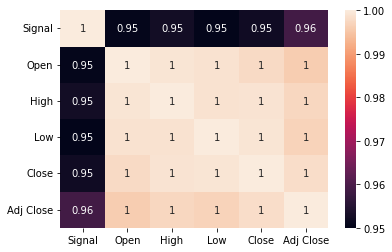

In [35]:
sns.heatmap(df.corr(), annot=True)

Text(0.5, 1.0, 'rolling correlation')

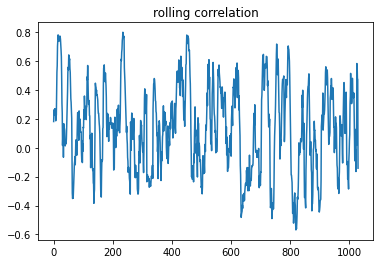

In [36]:
# check the rolling correlation between adj close price and signal

test_df = pd.concat([df.Signal, df['Adj Close']], axis=1)
roll_corr = []
for i in range(df.shape[0]-1):
    roll_corr += [np.array(test_df[['Signal', 'Adj Close']].iloc[i:i+21].corr())[0][1]]

plt.plot(roll_corr)
plt.title('rolling correlation')

In [37]:
original = df.copy(deep=True)

In [38]:
df['Detrended Signal 1'] = df.Signal.diff()

In [39]:
df['Detrended Signal 2'] = df['Detrended Signal 1'].diff()

In [40]:
df['Signal MACD'] = df['Signal'].rolling(5).mean() - df['Signal'].rolling(13).mean()

In [41]:
# The adjusted closing price of a stock takes into account dividend payments, splits and other factor which directly influence overall return
# adj_close_return_at_t = (adj_close_at_t+1 - adj_close_at_t) / adj_close_at_t
# also, turning into return (%) can detrend the price

df['Adj Close Daily Return'] = df['Adj Close'].pct_change().shift(-1)
df['Adj Close Monthly Return'] = df['Adj Close'].pct_change(21).shift(-21)

In [42]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
df = df.dropna(axis=0)

## Linear Regression
- X = Signal
- y = Adj Close Daily Return
- Fit 3m, 6m, 1y, 2y, 3y of data to predict the return on the following day

I will use R2 score to measure the predictive power of the signal in my analysis since Campbell (2008) showed that even very
small R2 statistics, but positive, can generate large
improvements in portfolio performance [1].

[1] Campbell, J. Y., & Thompson, S. B. (2008). Predicting excess stock returns out of sample: Can anything beat the historical average?. The Review of Financial Studies, 21(4), 1509-1531.

To avoid look ahead bias, I don't use the training day before the testing day to fit my model.

In [45]:
result = {}
for num_train_day in [63, 126, 252, 504, 756]:
    result[num_train_day] = []
    for i in range(df.shape[0]-1):
        try:
            X_train = df.iloc[i:i+num_train_day-1-1][['Signal']]
            y_train = df.iloc[i:i+num_train_day-1-1]['Adj Close Daily Return']
            X_test = df.iloc[[i+num_train_day]][['Signal']]
            y_test = df.iloc[[i+num_train_day]]['Adj Close Daily Return']

            lr = LinearRegression().fit(X_train, y_train)
            result[num_train_day].append(lr.predict(X_test))
        except:
            break

    r2 = r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day])
    print('R2 score:', r2, 'for num. of training day:',num_train_day)

R2 score: -0.051219142344756774 for num. of training day: 63
R2 score: -0.027722771290468184 for num. of training day: 126
R2 score: -0.012886245140204089 for num. of training day: 252
R2 score: -0.00332951800857062 for num. of training day: 504
R2 score: -0.0012725236724642208 for num. of training day: 756


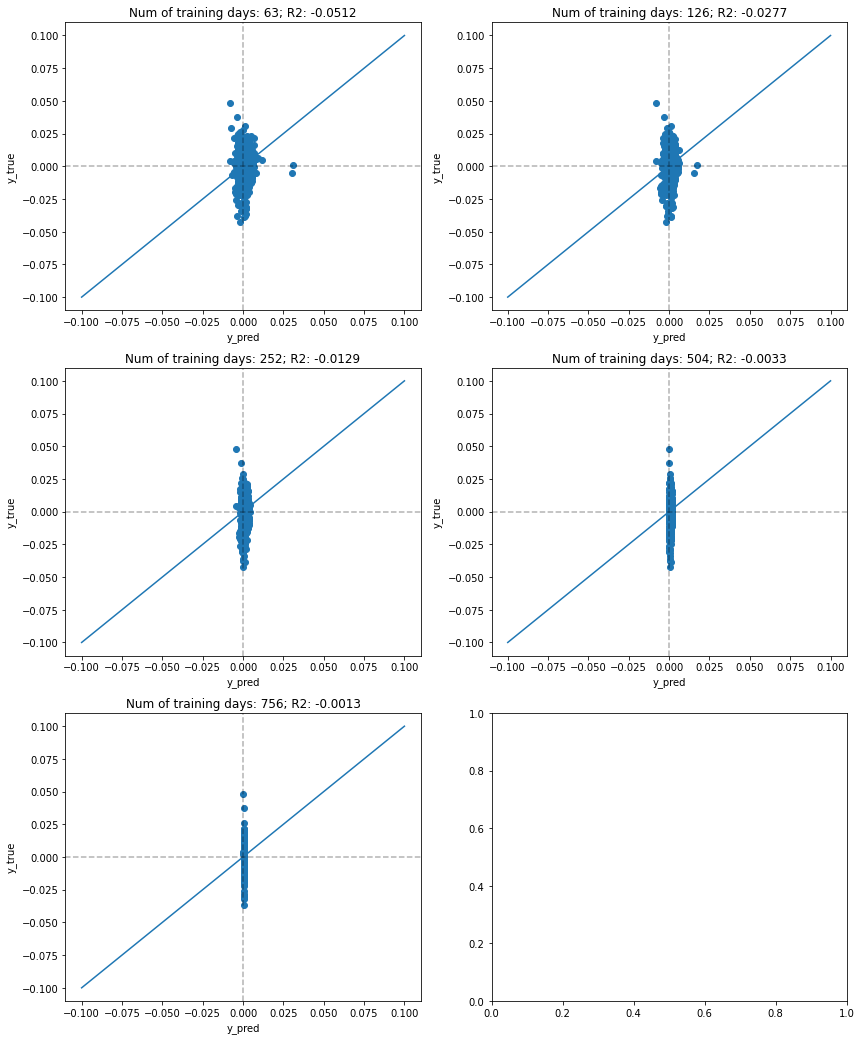

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(7*2, 6*3))
i = 0
for num_train_day in [63, 126, 252, 504, 756]:
    axes[i//2][i%2].scatter(result[num_train_day], df['Adj Close Daily Return'][len(result[num_train_day])*-1:])
    axes[i//2][i%2].set_title(
        f"Num of training days: {num_train_day}; R2: {r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day]):.04f}"
    )
    axes[i//2][i%2].set_ylabel('y_true')
    axes[i//2][i%2].set_xlabel('y_pred')
    axes[i//2][i%2].plot([-0.1, 0.1], [-0.1, 0.1])
    axes[i//2][i%2].axvline(x=0,c='k',linestyle='--',alpha=0.3)
    axes[i//2][i%2].axhline(y=0,c='k',linestyle='--',alpha=0.3)
    i += 1

## Linear Regression
- X = Signal
- y = Adj Close Monthly Return
- Fit 3m, 6m, 1y, 2y, 3y of data to predict the return on the following day

Comment 1: it doesn't look predictive to me currently. Maybe it has to be used with other signals

Comment 2: The R2 are negative and much smaller than the R2 score from the daily return. I think the signal is more likely a fast signal. So in the following part, I will use daily return as my response

In [47]:
result = {}
for num_train_day in [63, 126, 252, 504, 756]:
    result[num_train_day] = []
    for i in range(df.shape[0]-1):
        try:
            X_train = df.iloc[i:i+num_train_day-21-1][['Signal']]
            y_train = df.iloc[i:i+num_train_day-21-1]['Adj Close Monthly Return']
            X_test = df.iloc[[i+num_train_day]][['Signal']]
            y_test = df.iloc[[i+num_train_day]]['Adj Close Monthly Return']

            lr = LinearRegression().fit(X_train, y_train)
            result[num_train_day].append(lr.predict(X_test))
        except:
            break

    r2 = r2_score(df['Adj Close Monthly Return'][len(result[num_train_day])*-1:], result[num_train_day])
    print('R2 score:', r2, 'for num. of training day:',num_train_day)

R2 score: -0.6391985670104408 for num. of training day: 63
R2 score: -0.434075935306238 for num. of training day: 126
R2 score: -0.1743709552153967 for num. of training day: 252
R2 score: -0.04158501130713366 for num. of training day: 504
R2 score: -0.11488525182755827 for num. of training day: 756


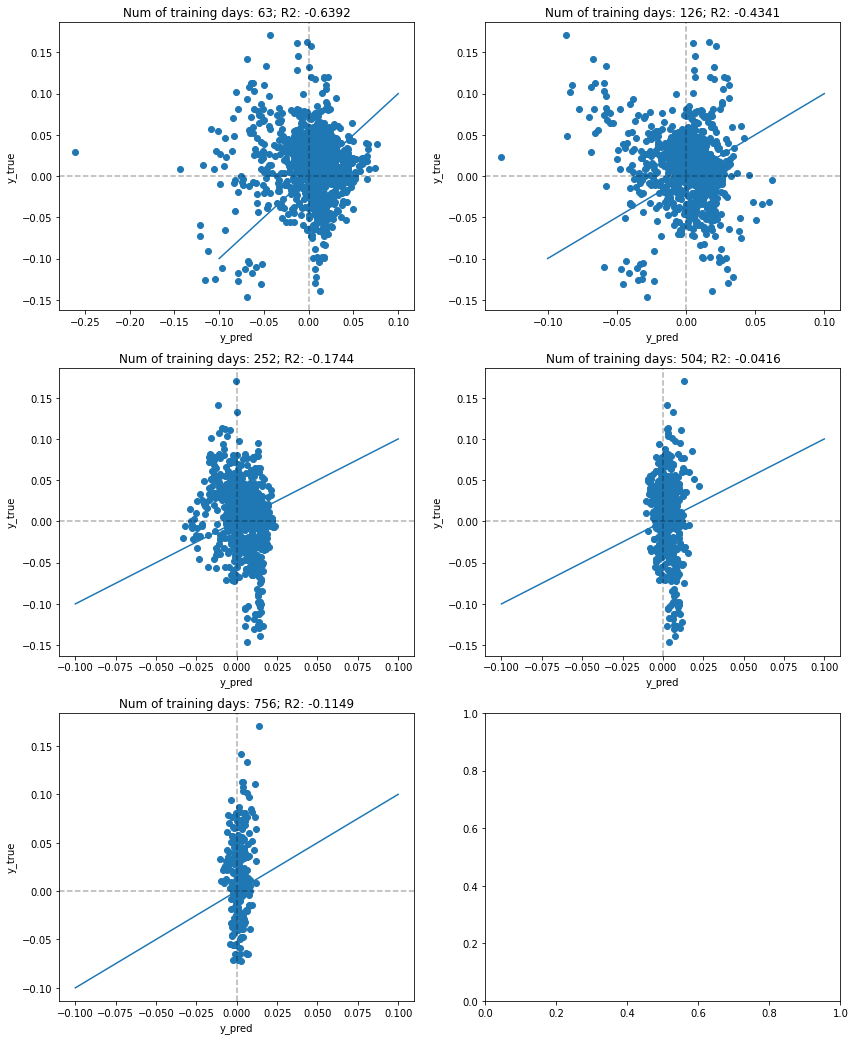

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(7*2, 6*3))
i = 0
for num_train_day in [63, 126, 252, 504, 756]:
    axes[i//2][i%2].scatter(result[num_train_day], df['Adj Close Monthly Return'][len(result[num_train_day])*-1:])
    axes[i//2][i%2].set_title(
        f"Num of training days: {num_train_day}; R2: {r2_score(df['Adj Close Monthly Return'][len(result[num_train_day])*-1:], result[num_train_day]):.04f}"
    )
    axes[i//2][i%2].set_ylabel('y_true')
    axes[i//2][i%2].set_xlabel('y_pred')
    axes[i//2][i%2].plot([-0.1, 0.1], [-0.1, 0.1])
    axes[i//2][i%2].axvline(x=0,c='k',linestyle='--',alpha=0.3)
    axes[i//2][i%2].axhline(y=0,c='k',linestyle='--',alpha=0.3)
    i += 1

## Linear Regression
- X = Detrended Signal (differencing = 1)
- y = Adj Close Daily Return
- Fit 3m, 6m, 1y, 2y, 3y of data to predict the return on the following day

Comment: it doesn't look predictive to me currently. Maybe it has to be used with other signals

In [49]:
result = {}
for num_train_day in [63, 126, 252, 504, 756]:
    result[num_train_day] = []
    for i in range(df.shape[0]-1):
        try:
            X_train = df.iloc[i:i+num_train_day-1-1][['Detrended Signal 1']]
            y_train = df.iloc[i:i+num_train_day-1-1]['Adj Close Daily Return']
            X_test = df.iloc[[i+num_train_day]][['Detrended Signal 1']]
            y_test = df.iloc[[i+num_train_day]]['Adj Close Daily Return']

            lr = LinearRegression().fit(X_train, y_train)
            result[num_train_day].append(lr.predict(X_test))
        except:
            break

    r2 = r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day])
    print('R2 score:', r2, 'for num. of training day:',num_train_day)

R2 score: -0.044818137751060805 for num. of training day: 63
R2 score: -0.015853805998601755 for num. of training day: 126
R2 score: -0.008242456908967633 for num. of training day: 252
R2 score: -0.0051823716906322925 for num. of training day: 504
R2 score: -0.0017197483497570776 for num. of training day: 756


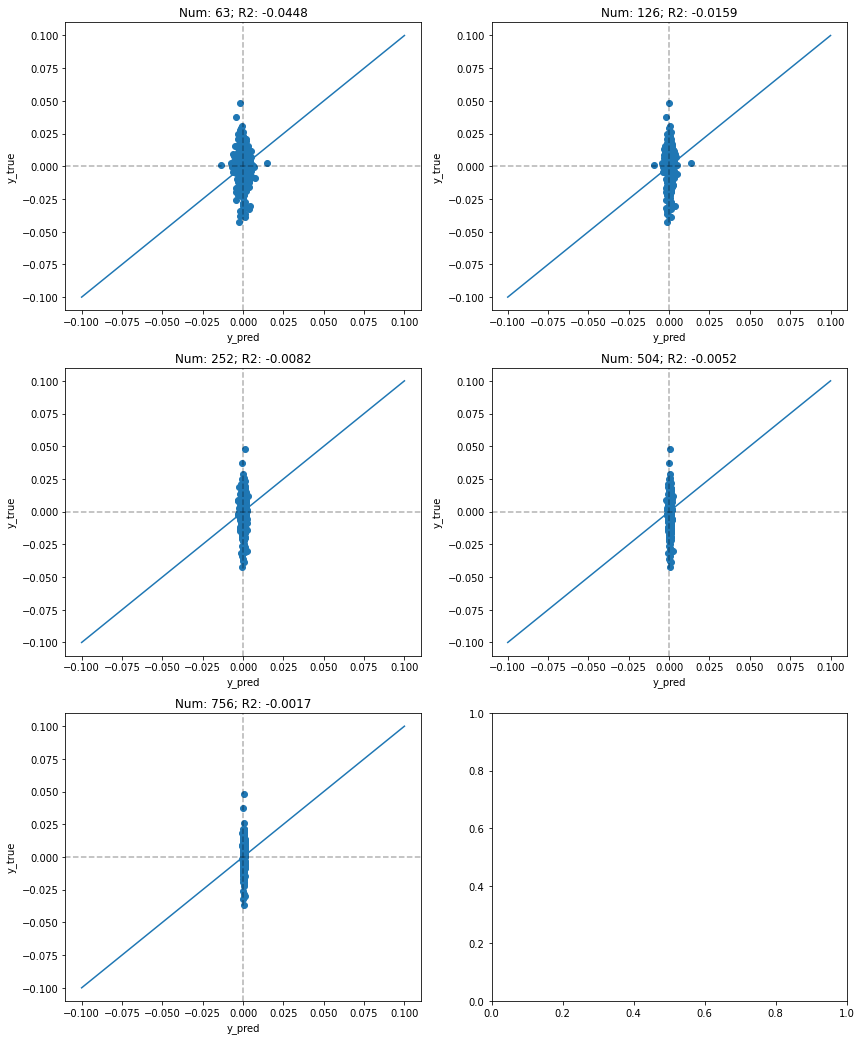

In [50]:
fig, axes = plt.subplots(3, 2, figsize=(7*2, 6*3))
i = 0
for num_train_day in [63, 126, 252, 504, 756]:
    axes[i//2][i%2].scatter(result[num_train_day], df['Adj Close Daily Return'][len(result[num_train_day])*-1:])
    axes[i//2][i%2].set_title(
        f"Num: {num_train_day}; R2: {r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day]):.04f}"
    )
    axes[i//2][i%2].set_ylabel('y_true')
    axes[i//2][i%2].set_xlabel('y_pred')
    axes[i//2][i%2].plot([-0.1, 0.1], [-0.1, 0.1])
    axes[i//2][i%2].axvline(x=0,c='k',linestyle='--',alpha=0.3)
    axes[i//2][i%2].axhline(y=0,c='k',linestyle='--',alpha=0.3)
    i += 1

## Linear Regression by Train Test Split
- X = Signal
- y = Adj Close Daily Return
- test size = 0.2

Comment 1: although the R2 is positive, the result from the plot shows the lack of predictive power when y_true is negative

Comment 2: It may be biased toward this testing dataset. In the moment, not conclusive.

In [51]:
train = df.iloc[:int(df.shape[0]*0.8)]
test = df.iloc[int(df.shape[0]*0.8):]
X_train = train[['Signal']]
X_test = test[['Signal']]
y_train = train['Adj Close Daily Return']
y_test = test['Adj Close Daily Return']

In [52]:
lr = LinearRegression().fit(X_train[:-2], y_train[:-2])
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.0008505015666929738

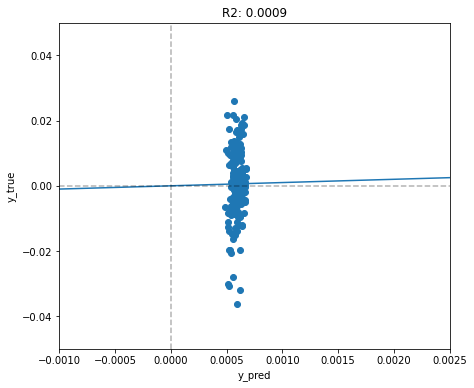

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(y_pred, y_test)
ax.set_title(
    f"R2: {r2_score(y_test, y_pred):.04f}"
)
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
ax.plot([-0.1, 0.1], [-0.1, 0.1])
ax.set_xlim([-.0010, .0025])
ax.set_ylim([-.05, .05])
ax.axvline(x=0,c='k',linestyle='--',alpha=0.3)
ax.axhline(y=0,c='k',linestyle='--',alpha=0.3)

## Linear Regression by Train Test Split
- X = Signal
- y = Adj Close Daily Return
- test size = 0.3

Comment 1: the result from the plot shows the lack of predictive power when y_true is negative

In [54]:
train = df.iloc[:int(df.shape[0]*0.7)]
test = df.iloc[int(df.shape[0]*0.7):]
X_train = train[['Signal']]
X_test = test[['Signal']]
y_train = train['Adj Close Daily Return']
y_test = test['Adj Close Daily Return']

In [55]:
lr = LinearRegression().fit(X_train[:-2], y_train[:-2])
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

-0.007237709715604224

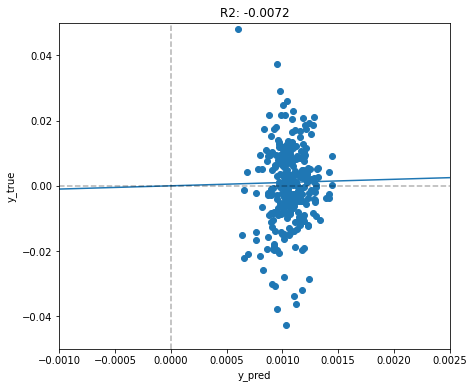

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(y_pred, y_test)
ax.set_title(
    f"R2: {r2_score(y_test, y_pred):.04f}"
)
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
ax.plot([-0.1, 0.1], [-0.1, 0.1])
ax.set_xlim([-.0010, .0025])
ax.set_ylim([-.05, .05])
ax.axvline(x=0,c='k',linestyle='--',alpha=0.3)
ax.axhline(y=0,c='k',linestyle='--',alpha=0.3)

## Linear Regression by Train Test Split
- X = Signal, Detrend Signals (differencing 1 and 2)
- y = Adj Close Daily Return
- test size = 0.3

Comment 1: the result from the plot shows the lack of predictive power when y_true is negative

In [57]:
X_train = train[['Signal', 'Detrended Signal 1', 'Detrended Signal 2']]
X_test = test[['Signal', 'Detrended Signal 1', 'Detrended Signal 2']]
y_train = train['Adj Close Daily Return']
y_test = test['Adj Close Daily Return']

In [58]:
lr = LinearRegression().fit(X_train[:-2], y_train[:-2])
y_pred = lr.predict(X_test)

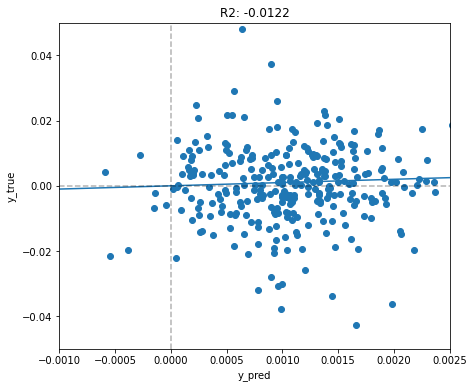

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(y_pred, y_test)
ax.set_title(
    f"R2: {r2_score(y_test, y_pred):.04f}"
)
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
ax.plot([-0.1, 0.1], [-0.1, 0.1])
ax.set_xlim([-.0010, .0025])
ax.set_ylim([-.05, .05])
ax.axvline(x=0,c='k',linestyle='--',alpha=0.3)
ax.axhline(y=0,c='k',linestyle='--',alpha=0.3)

## Linear Regression with PCA Detrended Signals
- X = Signal, 1st PC of Detrended Signals
- y = Adj Close Daily Return
- Fit 3m, 6m, 1y, 2y, 3y of data to predict the return on the following day

Comment 1: the result shows this method may not be a good way to do the data engineering process

In [60]:
# As these two signals can be explained by 1 PC mostly, I would try to raplace them by their first PC
pca = PCA()
pca.fit(df[['Detrended Signal 1', 'Detrended Signal 2']])
pca.explained_variance_ratio_

array([0.95012814, 0.04987186])

In [61]:
result = {}
# training period: 3m, 6m, 1y, 2y, 3y
for num_train_day in [63, 126, 252, 504, 756]:
    result[num_train_day] = []
    for i in range(df.shape[0]-1):
        try:
            # avoid data leakage / look ahead bias
            scaler = RobustScaler()
            X_train = df.iloc[i:i+num_train_day-2][['Signal', 'Detrended Signal 1', 'Detrended Signal 2']]
            y_train = df.iloc[i:i+num_train_day-2]['Adj Close Daily Return']
            X_test = df.iloc[[i+num_train_day]][['Signal', 'Detrended Signal 1', 'Detrended Signal 2']]
            y_test = df.iloc[[i+num_train_day]]['Adj Close Daily Return']

            scaler.fit(X_train)
            X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

            pca = PCA(n_components=1)
            pca.fit(X_train[['Detrended Signal 1', 'Detrended Signal 2']])
            X_train_2 = pca.transform(X_train[['Detrended Signal 1', 'Detrended Signal 2']])
            X_test_2 = pca.transform(X_test[['Detrended Signal 1', 'Detrended Signal 2']])

            X_train = np.c_[X_train[['Signal']].to_numpy(), X_train_2]
            X_test = np.c_[X_test[['Signal']].to_numpy(), X_test_2]

            lr = LinearRegression().fit(X_train, y_train)
            result[num_train_day].append(lr.predict(X_test))
        except:
            break

    r2 = r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day])
    print('R2 score:', r2, 'for num. of training day:',num_train_day)

R2 score: -0.16982631190982045 for num. of training day: 63
R2 score: -0.04028142619132824 for num. of training day: 126
R2 score: -0.01590413247495448 for num. of training day: 252
R2 score: -0.003082099205802269 for num. of training day: 504
R2 score: -0.00098639088733532 for num. of training day: 756


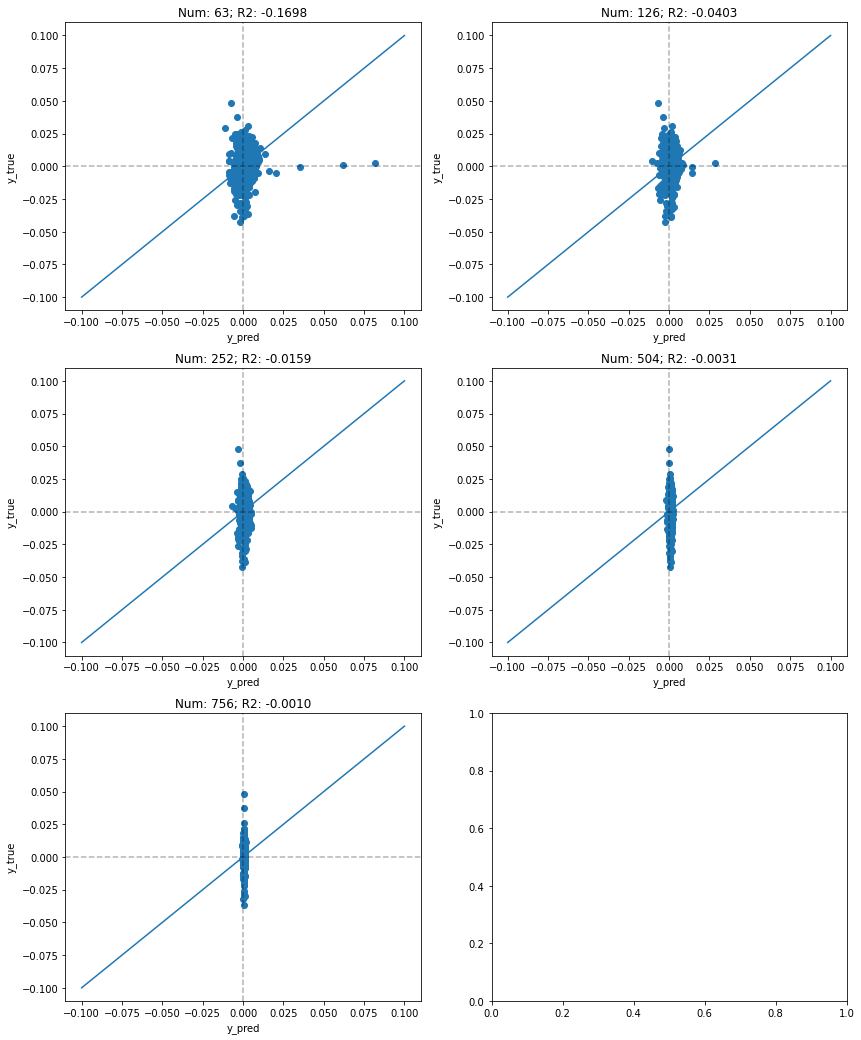

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(7*2, 6*3))
i = 0
for num_train_day in [63, 126, 252, 504, 756]:
    axes[i//2][i%2].scatter(result[num_train_day], df['Adj Close Daily Return'][len(result[num_train_day])*-1:])
    axes[i//2][i%2].set_title(
        f"Num: {num_train_day}; R2: {r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day]):.04f}"
    )
    axes[i//2][i%2].set_ylabel('y_true')
    axes[i//2][i%2].set_xlabel('y_pred')
    axes[i//2][i%2].plot([-0.1, 0.1], [-0.1, 0.1])
    axes[i//2][i%2].axvline(x=0,c='k',linestyle='--',alpha=0.3)
    axes[i//2][i%2].axhline(y=0,c='k',linestyle='--',alpha=0.3)
    i += 1

## Linear Regression with Signal MACD by Train Test Split
- X = Signal MACD
- y = Adj Close Daily Return
- test size = 0.2

Comment 1: The correlation is high

Comment 2: The r2 is positive and relatively high but it may be biased toward this dataset

Comment 3: Not conclusive in the moment


In [64]:
print("Correlation between Signal MACD and Adj Close Daily Return:", (df['Signal'].rolling(5).mean() - df['Signal'].rolling(13).mean()).corr(df['Adj Close Daily Return']))

x = (df['Signal'].rolling(5).mean() - df['Signal'].rolling(13).mean()).dropna()
y = df['Adj Close Daily Return'][x.index]

x_train = x[:int(len(x)*0.8)].to_numpy().reshape(-1, 1)
y_train = y[:int(len(x)*0.8)].to_numpy().reshape(-1, 1)
x_test = x[int(len(x)*0.8):].to_numpy().reshape(-1, 1)
y_test = y[int(len(x)*0.8):].to_numpy().reshape(-1, 1)

lr = LinearRegression().fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(f"R2: {r2_score(y_test, y_pred):.04f}")

Correlation between Signal MACD and Adj Close Daily Return: 0.2796573266558801
R2: 0.0780


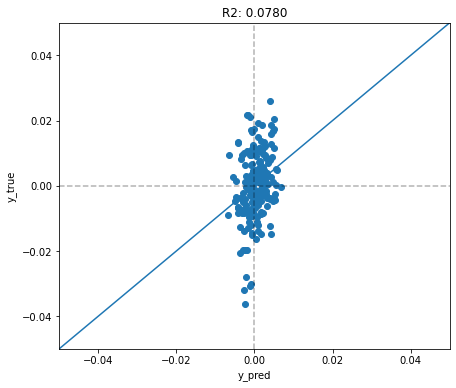

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(y_pred, y_test)
ax.set_title(
    f"R2: {r2_score(y_test, y_pred):.04f}"
)
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
ax.plot([-0.1, 0.1], [-0.1, 0.1])
ax.set_xlim([-.05, .05])
ax.set_ylim([-.05, .05])
ax.axvline(x=0,c='k',linestyle='--',alpha=0.3)
ax.axhline(y=0,c='k',linestyle='--',alpha=0.3)

## Linear Regression with Signal MACD
- X = Signal MACD
- y = Adj Close Daily Return
- Fit 3m, 6m, 1y, 2y, 3y of data to predict the return on the following day

Comment 1: the positive r2 shows that it is a quite robust predictor to predict the daily return even I did not include the last 3 training days to fit the model

Comment 2: the current predictor is robust but not optimized. To improve, we can try different pairs of signal moving average.

In [66]:
result = {}
# training period: 3m, 6m, 1y, 2y, 3y
for num_train_day in [63, 126, 252, 504, 756]:
    result[num_train_day] = []
    for i in range(df.shape[0]-1):
        try:
            X_train = df.iloc[i:i+num_train_day-3][['Signal MACD']]
            y_train = df.iloc[i:i+num_train_day-3]['Adj Close Daily Return']
            X_test = df.iloc[[i+num_train_day]][['Signal MACD']]
            y_test = df.iloc[[i+num_train_day]]['Adj Close Daily Return']

            lr = LinearRegression().fit(X_train, y_train)
            result[num_train_day].append(lr.predict(X_test))
        except:
            break

    r2 = r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day])
    print('R2 score:', r2, 'for num. of training day:',num_train_day)

R2 score: 0.054121544429400426 for num. of training day: 63
R2 score: 0.06080618905807267 for num. of training day: 126
R2 score: 0.08345980565745881 for num. of training day: 252
R2 score: 0.1001368471639047 for num. of training day: 504
R2 score: 0.10781360543695795 for num. of training day: 756


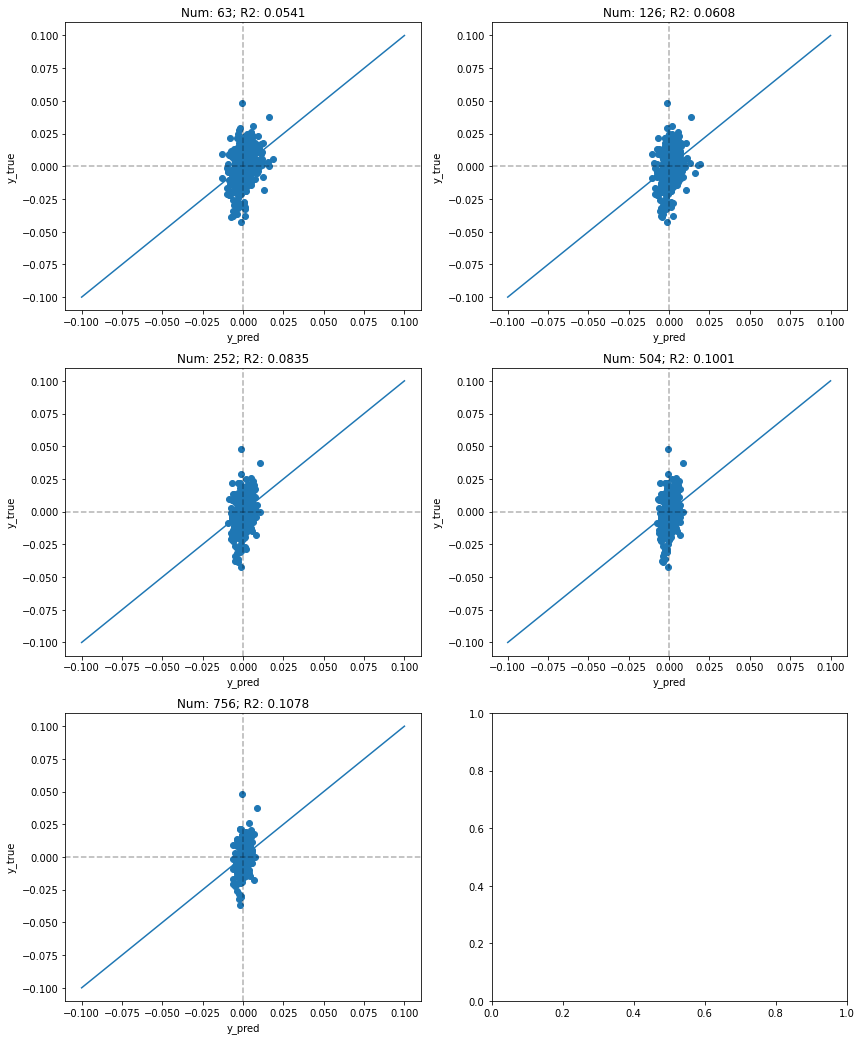

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(7*2, 6*3))
i = 0
for num_train_day in [63, 126, 252, 504, 756]:
    axes[i//2][i%2].scatter(result[num_train_day], df['Adj Close Daily Return'][len(result[num_train_day])*-1:])
    axes[i//2][i%2].set_title(
        f"Num: {num_train_day}; R2: {r2_score(df['Adj Close Daily Return'][len(result[num_train_day])*-1:], result[num_train_day]):.04f}"
    )
    axes[i//2][i%2].set_ylabel('y_true')
    axes[i//2][i%2].set_xlabel('y_pred')
    axes[i//2][i%2].plot([-0.1, 0.1], [-0.1, 0.1])
    axes[i//2][i%2].axvline(x=0,c='k',linestyle='--',alpha=0.3)
    axes[i//2][i%2].axhline(y=0,c='k',linestyle='--',alpha=0.3)
    i += 1